# Citibike Stations' Inflow to Outflow Trips Ratio
Group Members:
Cindy Y. Liu, Yuxiang Zhang

# 1) IDEA

   # Citibike Stations in Manhattan have less inflow trips than those in Brooklyn.
   Among more than 400 citibike stations in New York City, most of them are concentrated in Manhattan and Brooklyn. People ride bikes around their communities, tourist areas or cross boroughs too. 
    
   We are interested in this because we want to explore whether there are certain stations are popular (indicated by the number of bike trips coming to the station),and if any, whether the difference varies between stations of different boroughs. 
    
   We count the toal number of journeys which start from/end at each station and name them the outflow journeys and inflow jouneys. They are used in the Inflow/Outflow Ratio formula as follow.

$R_{I/O}=\frac{Inflow}{Inflow+Outflow}$


# 2) Testable Hypothesis
   Hypothesis 1: comparing the mean value of ratios for two samples:
    
      - NULL HYPOTHESIS: The ratio of inflow trips to total trips for Manhattan stations is higher than the ratio for Brooklyn stations.   
      - ALTERNATIVE HYPOTHESIS: The ratio of inflow trips to total trips for Manhattan stations is equal or smaller than that in Brooklyn.
       
   Hypothesis 2: comparing the proportion of stations which have ratio > 0.5 to total stations for two samples:
      
      - NULL HYPOTHESIS: the proportion of Manhattan stations which have more inflow trips than outflow trips is larger than that in Brooklyn.
      - ALTERNATIVE HYPERTHESIS: the proportion of Manhattan stations which have more inflow trips than outflow trips is equal or smaller than that in Brooklyn.
 
# 3) Confidence Level 

   alpha = .05

# 4) Hypothesis Test

   We used the Z-test for both hypothesis 1 and 2.

In [1]:
# Load Default settings
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Citibike data
df = pd.read_csv('201508-citibike-tripdata.csv')

In [3]:
# Drop unnecessary features
df = df.drop(['tripduration','starttime','stoptime'],axis=1)

In [4]:
# Store the information of stations into a csv file which includes longitude,latitude and station id
start = pd.DataFrame({'ID': df['start station id'], \
                    'Latitude': df['start station latitude'],\
                    'Longitude':df['start station longitude']})
end = pd.DataFrame({'ID': df['end station id'], \
                    'Latitude': df['end station latitude'],\
                    'Longitude':df['end station longitude']})
merged = pd.concat([start,end],axis=0)
merged = merged.drop_duplicates('ID')
merged.to_csv('station.csv')    

We use the Geopy package to [reverse geocoding](https://en.wikipedia.org/wiki/Reverse_geocoding) by converting geographic coordinates (latitude and longitude) into street addresses. Based on these, we get the corresponding borough information for each Citibike station.

In [5]:
from geopy.geocoders import Nominatim
import numpy as np
stations = pd.read_csv('station.csv')
output = np.empty(len(stations), dtype='object')
for index,station in stations.iterrows():
    geolocator = Nominatim()
    location = geolocator.reverse("%s,%s"%(str(station['Latitude']), str(station['Longitude'])),timeout=10)
    if location.raw["address"]["county"]=="New York County"or location.raw["address"]["county"]=="New York":
        output[index]="Manhattan"
    else:
        if location.raw["address"]["county"]=="Kings County":
            output[index]="Brooklyn"
        else:
            if location.raw["address"]["county"]=="Queens County":
                output[index]="Queens"
            else:
                output[index]=location.raw["address"]["county"]

Then we store the borough information of each station into a csv file named 'borough'.

In [6]:
output.tofile('borough.csv',sep='\n')

In [7]:
# Combine the station ID and its corresponding borough information into a new dataframe and export it to a new csv file
# named 'stationbyborough'
borough = output
station_by_borough = pd.DataFrame({"ID":stations["ID"],\
                                "Borough":borough})
station_by_borough.to_csv('stationbyborough.csv',sep=',')

In [8]:
# Load 'stations by borough' csv file
stations_by_borough = pd.read_csv('stationbyborough.csv')

In [9]:
# Create empty arrays for storing the number of inflow trips, outflow trips, and the ratio of inflow trips to total trips for each citibike station
in_jour, out_jour, in_out_ratio = np.zeros(len(stations_by_borough)),np.zeros(len(stations_by_borough)),np.zeros(len(stations_by_borough))

In [10]:
# Iterate through all the stations to get the total number of inflow and outflow trips of each station
for index, station in stations_by_borough.iterrows():
    start = sum(df['start station id']==station['ID'])
    end = sum(df['end station id']==station['ID'])
    out_jour[index]= start
    in_jour[index]= end
    in_out_ratio[index] = end/float(end+start)

In [11]:
# Create a new data frame which includes all the inflow and outflow information of each station
results = pd.DataFrame({'Sid':stations_by_borough['ID'],\
                      'Income':in_jour,\
                      'Outcome':out_jour,\
                      'Ratio':in_out_ratio,\
                      'Borough':stations_by_borough['Borough']})
cols = ['Sid','Income','Outcome','Ratio','Borough']
results = results[cols]
results.to_csv('result.csv')

In [12]:
# Display the summary statistics for the new data frame including all the inflow and outflow information of each station
results.describe()

,Sid,Income,Outcome,Ratio
count,421.000000,421.000000,421.000000,421.000000
mean,1020.299287,2800.579572,2800.579572,0.503057
std,1143.676593,2437.574067,2478.491485,0.041569
min,72.000000,1.000000,0.000000,0.345114
25%,317.000000,684.000000,674.000000,0.495238
50%,434.000000,2419.000000,2486.000000,0.501034
75%,2001.000000,4296.000000,4276.000000,0.507428
max,3224.000000,11912.000000,14498.000000,1.000000


In [13]:
# Calculate the number of both Manhattan and Brooklyn stations
pd.value_counts(results['Borough'].values.ravel())

Manhattan    261
Brooklyn     148
Queens        12
dtype: int64

## Statistical Analysis

In [14]:
# Create new dataframes for Manhattan and Brooklyn seperately
manhattan = results[results['Borough']=='Manhattan']
brooklyn = results[results['Borough']=='Brooklyn']

norm_m = 1
norm_b = 1

error_m = np.sqrt(manhattan['Ratio'].count())
error_b = np.sqrt(brooklyn['Ratio'].count())

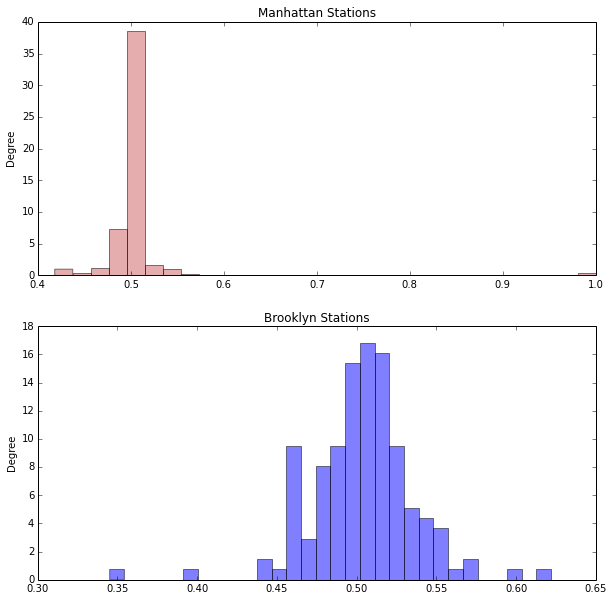

In [15]:
# Create histograms for Manhattan and Brooklyn's inflow to outflow trips ratio
from matplotlib import gridspec

fig = pl.figure(figsize(10,10))
gs = gridspec.GridSpec(2, 1)

# Plot the histogram of inflow to outflow trips ratio for Manhattan stations
ax = fig.add_subplot(gs[0,0])
manhattan['Ratio'].plot(kind="hist",yerr=[((error_m)/norm_m,(error_m)/norm_m)],\
                        bins=30,color='IndianRed', alpha=0.5,normed=1)
ax.set_title('Manhattan Stations')

# Plot the histogram of inflow to outflow trips ratio for Brooklyn stations
bx = fig.add_subplot(gs[1,0])
brooklyn['Ratio'].plot(kind="hist",yerr=[((error_b)/norm_b,(error_b)/norm_b)],\
                       bins=30, alpha=0.5,normed=1)
bx.set_title('Brooklyn Stations')

In [16]:
# Display summary statitics for Manhattan and Brooklyn's inflow to outflow trips ratio
manhattan['Ratio'].describe()

count    261.000000
mean       0.503116
std        0.046508
min        0.418210
25%        0.497547
50%        0.500660
75%        0.503913
max        1.000000
Name: Ratio, dtype: float64

In [17]:
brooklyn['Ratio'].describe()

count    148.000000
mean       0.503424
std        0.032732
min        0.345114
25%        0.487157
50%        0.504792
75%        0.519031
max        0.622040
Name: Ratio, dtype: float64

# Hypothesis: 
Manhattan's citibike stations have less inflow trips than Brooklyn.

# Z test for the mean of inflow to total trips ratios for two samples

$H_{0} : mean_m-mean_b>0$

$H_{\alpha}: mean_m-mean_b<=0$

In [18]:
# Calculate the mean and standard deviation for two samples
mean_m = np.mean(manhattan['Ratio'])
mean_b = np.mean(brooklyn['Ratio'])
std_m = np.std(manhattan['Ratio'])
std_b = np.std(brooklyn['Ratio'])
n_m = len(manhattan)
n_b = len(brooklyn)

# Create formula to calculate the standard error for the difference
SE = lambda sd1,sd2,n1,n2: np.sqrt(sd1**2/float(n1)+sd2**2/float(n2))
se = SE(std_m, std_b, n_m, n_b)

In [19]:
# Use the two sample z-test to evaluate the difference between two groups
z_1 = (mean_m - mean_b)/se
print 'z_1 = %f' % z_1

z_1 = -0.078344


In [20]:
# According to the Z-score to, compute the p-value and compare against the critical value.
p_1 = 0.5319
alpha = 0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)

    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

    
report_result(p_1,alpha)

Is the p value 0.53 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected


# Z test for the proportion of stations which have more inflow trips than outflow trips (ratio > 0.5) to the total stations  in two samples.

$H_{0} : p_m-p_b>0$

$H_{\alpha}: p_m-p_b<=0$

In [21]:
P_0 = sum(manhattan['Ratio']>=0.5)/float(len(manhattan))
P_1 = sum(brooklyn['Ratio']>=0.5)/float(len(brooklyn))

n_0 = len(manhattan)
n_1 = len(brooklyn)

Nt_0 = P_0*n_0
Nt_1 = P_1*n_1
print 'P_0 = %f,P_1 = %f,n_0 = %f,n_1 = %f'%(P_0, P_1, n_0, n_1)

# Pooled Sample Proportion
psp =(P_0*n_0+P_1*n_1)/(n_1+n_0)

SE = lambda p, n1, n2: np.sqrt(psp*(1-psp)*(1/float(n1)+1/float(n2)))

se = SE(P_0,n_0,n_1)

# Z-score
zscore = lambda p0, p1, s : (p0-p1)/s
z_2 = zscore(P_1, P_0, se)
print'z_2 = %f' % z_2

P_0 = 0.578544,P_1 = 0.581081,n_0 = 261.000000,n_1 = 148.000000
z_2 = 0.049946


In [22]:
p = 1 - 0.6179
alpha = 0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)
   
    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

report_result(p,alpha)

Is the p value 0.38 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected
